<a href="https://colab.research.google.com/github/vjardimb/nn-model-optimization/blob/main/pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pruning on MNIST and Tensorflow

The goal of this notebook is to get familiar with the concept and different techniques of pruning on TensorFlow neural networks using the MNIST dataset. Pruning is a model optimization techinique whose goal is to shrink the model's size by removing from it a considerable amount of parameters while having a negligible performance difference.



## Summary

1. Train and evaluate a Tensorflow model to classify the MNIST dataset samples.
2. Train a 3x and a 10x smaller model and prune it.
3. Fine tuning new models and check their perfomance
4. Compare models' results



In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorboard

from keras.models import Sequential
from keras.layers import (
    InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
)

In [2]:
# check GPU availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

###Hyperparameters

In [33]:
N_CHANNELS = 1
IMG_SHAPE = (28, 28)
N_CLASSES = 10
INPUT_SHAPE = (28,28,1)

BATCH_SIZE = 128
EPOCHS = 10

INITIAL_SPARSITY = 0.5
FINAL_SPARSITY = 0.9
PRUNING_EPOCHS = 4

###Load Data

In [4]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape, test_images.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


### Preprocessing

In [5]:
# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# add channels dimensions
if keras.backend.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1, IMG_SHAPE[0], IMG_SHAPE[1]).astype('float32')
  test_images = test_images.reshape(test_images.shape[0], 1, IMG_SHAPE[0], IMG_SHAPE[1]).astype('float32')
else:
  train_images = train_images.reshape(train_images.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1).astype('float32')
  test_images = test_images.reshape(test_images.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1).astype('float32')

# one-hot encoding on classes labels
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

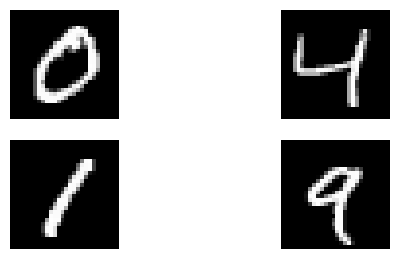

In [6]:
# plot four images as gray scale
for i in range(1,5):
  plt.subplot(320+i)
  plt.imshow(train_images[i],cmap='gray')
  plt.axis('off')

###Create Initial Model (No Prunning)

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMG_SHAPE[0],IMG_SHAPE[1],1), padding="same"))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))

model.add(Activation('softmax')) # Softmax activation enables us to calculate the output based on the probabilities

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 26, 26, 32)        0

###Model Training

In [9]:
import tempfile

logdir = tempfile.mkdtemp()
print('Writing training logs to ' + logdir)

Writing training logs to /tmp/tmp_idnfbmr


In [11]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          callbacks=callbacks,
          validation_data=(test_images, test_labels))
score = model.evaluate(test_images, test_labels, verbose=0)

Epoch 1/10
469/469 [==============================] - 22s 12ms/step - loss: 0.0850 - accuracy: 0.9739 - val_loss: 0.0540 - val_accuracy: 0.9855
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.0664 - val_accuracy: 0.9789
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0288 - val_accuracy: 0.9915
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 0.0201 - val_accuracy: 0.9925
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0315 - val_accuracy: 0.9905
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.0505 - val_accuracy: 0.9843
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0274 - val_accuracy: 0.992

### Evaluate Model

In [26]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

Baseline test accuracy: 0.9902999997138977


### Save Model for Later Comparison

In [15]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
!ls /content/gdrive/My\ Drive/ML\ Projects/pruning

In [25]:
model_save_name = 'unpruned_model'
path = f"/content/gdrive/My Drive/ML Projects/pruning/{model_save_name}.h5"
model.save(path)

### Fine-tune Pruned Model

In [29]:
!pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.0 MB/s eta 0:00:00


In [42]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_images = train_images.shape[0]
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * PRUNING_EPOCHS

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

# create pruned model based on the original one
pruned_model = prune_low_magnitude(model, **pruning_params)

# recompile pruned model
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 32)        610       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_batch_  (None, 28, 28, 32)        129       
 normalization (PruneLowMag                                      
 nitude)                                                         
                                                                 
 prune_low_magnitude_activa  (None, 28, 28, 32)        1         
 tion (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 26, 26, 32)        18466     
 _1 (PruneLowMagnitude)                                          
                                                        

In [43]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

pruned_model.fit(
    train_images,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=PRUNING_EPOCHS,
    callbacks=callbacks)

Epoch 1/4
  4/469 [..............................] - ETA: 8s - loss: 0.0041 - accuracy: 1.0000   

469/469 [==============================] - 20s 28ms/step - loss: 0.0096 - accuracy: 0.9969
Epoch 2/4
469/469 [==============================] - 8s 16ms/step - loss: 0.0083 - accuracy: 0.9979
Epoch 3/4
469/469 [==============================] - 8s 17ms/step - loss: 0.0067 - accuracy: 0.9984
Epoch 4/4
469/469 [==============================] - 9s 18ms/step - loss: 0.0031 - accuracy: 0.9996


### Compare Performances

In [45]:
_, model_for_pruning_accuracy = pruned_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9902999997138977
Pruned test accuracy: 0.9947999715805054


### Save Pruned Model

In [49]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

model_save_name = 'pruned_model'
path = f"/content/gdrive/My Drive/ML Projects/pruning/{model_save_name}.h5"
model_for_export.save(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Compress Model Using TFLite

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

In [53]:
model_save_name = 'pruned_tflite_model'
path = f"/content/gdrive/My Drive/ML Projects/pruning/{model_save_name}.tflite"

# Save the model.
with open(path, 'wb') as f:
  f.write(pruned_tflite_model)

### Conclusion

A model was initially trained to classify hand-written digits on the MNIST dataset. A accuracy of 99% was achieved in a model of 6.9 Mb.

Using pruning techniques, the 99% was maintained and the model size shrinked to 2.3 Mb, representing a size reduction of 67%.